<a href="https://colab.research.google.com/github/WolfgangHou/Loan_Approval_Prediction/blob/main/Loan_Approval_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s4e10_path = kagglehub.competition_download('playground-series-s4e10')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


# 目標
透過分析申請貸款客人資料，建立分類模型預測該客人貸款申請案通過核准的機率。

# 導入資料

In [ ]:
df = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

# 初步資料探索

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 確認資料類型與資料缺失情況
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [ ]:
# 確認是否有缺失資料
df.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [ ]:
# 檢查資料內容
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [ ]:
# 確認類別資料與其種類分項
cate = df.select_dtypes('object')
for i in cate.columns:
    print(i,cate[i].unique())

person_home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file ['N' 'Y']


In [ ]:
# 檢查數值資料欄位統計數字
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


# 數據前處理與視覺化

In [ ]:
# 移除id欄位
df = df.drop('id', axis=1)

## 繪製各個欄位數值分佈箱形圖


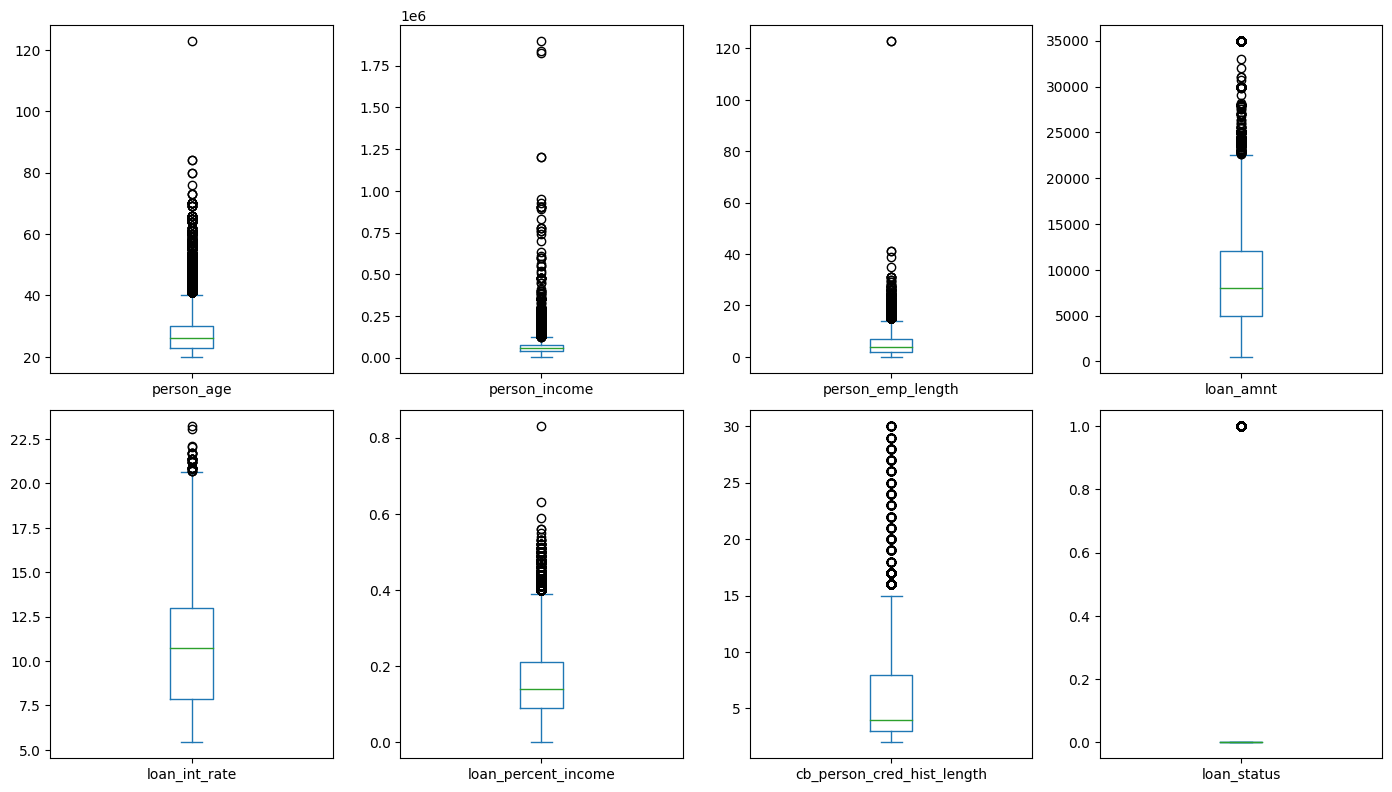

In [ ]:
df.plot(kind='box',subplots=True, layout=(-1, 4), figsize=(14,8))
plt.tight_layout(pad=1.0)


## 繪製各欄位直方圖，以確認資料分佈情況

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

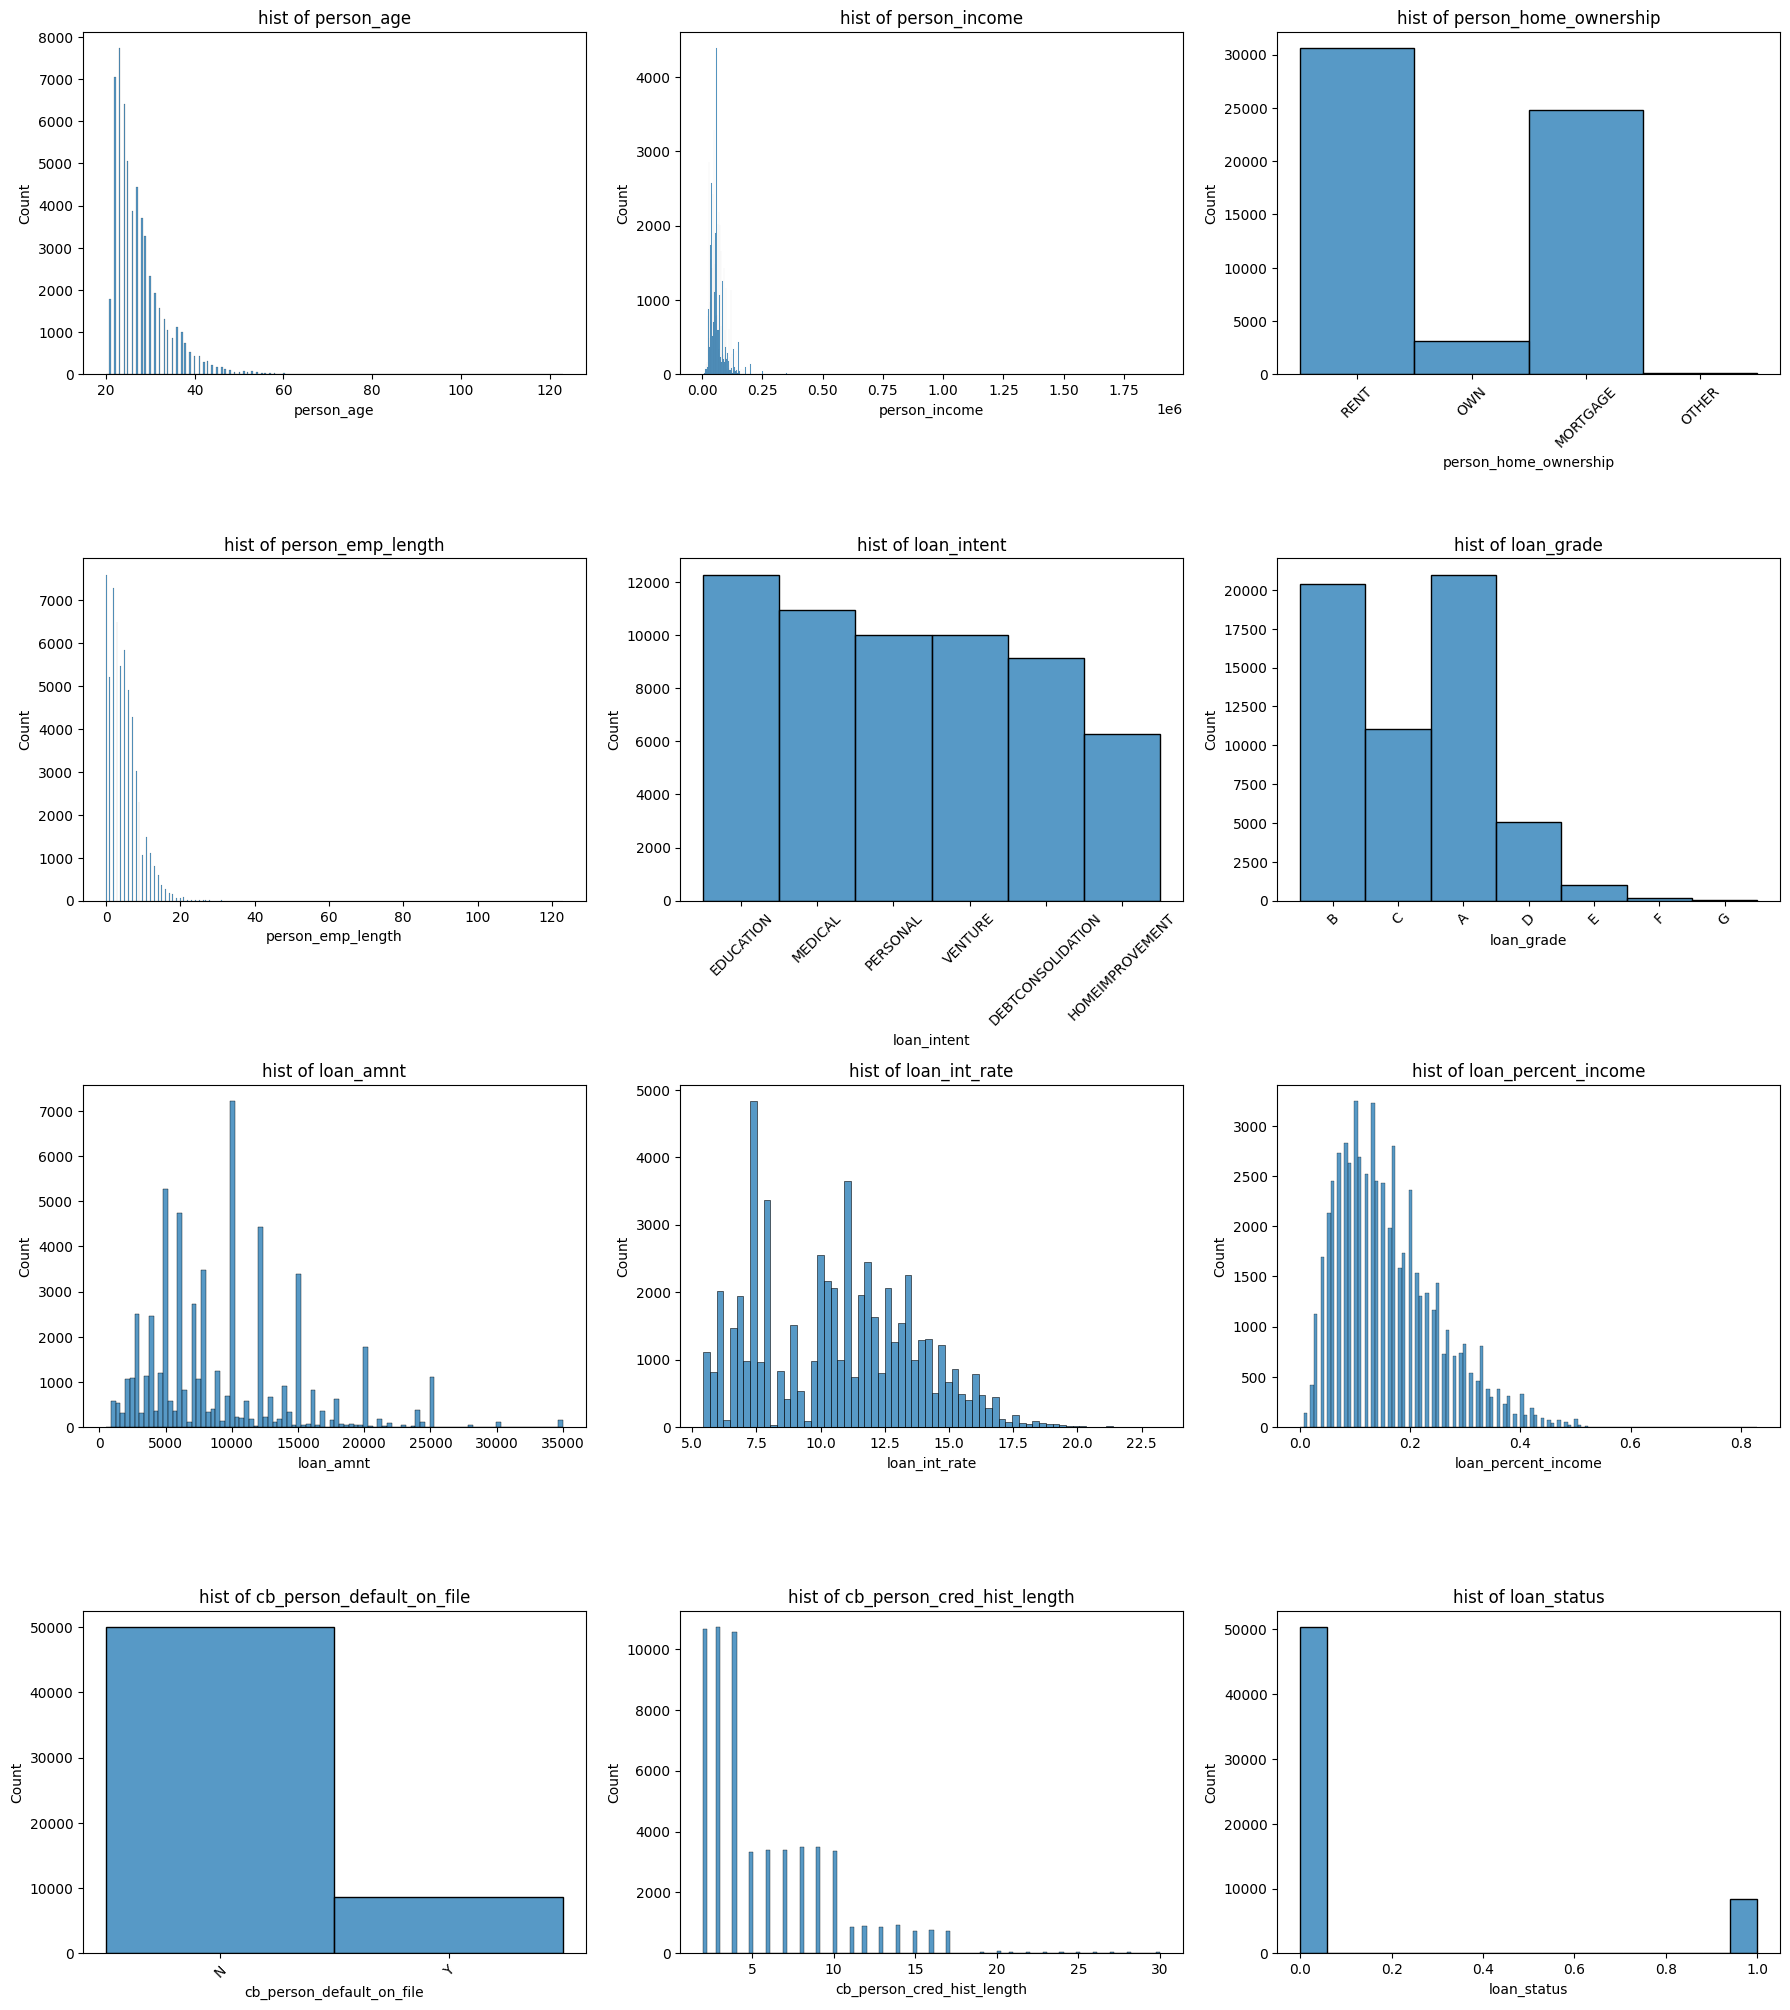

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=5, figsize=(18, 25))
axes = axes.ravel()

for i, col in enumerate(df):
    # 當欄位為物件型（字串或類別型）時處理
    if df[col].dtype == 'object':
        sns.histplot(df[col], ax=axes[i], discrete=True)  # 使用 discrete 設定直方圖為離散型
        axes[i].tick_params(axis='x', rotation=45)  # 旋轉 45 度
    else:
        sns.histplot(df[col], ax=axes[i])  # 其他數值型欄位的直方圖

    axes[i].set_title(f'hist of {col}')

# 隱藏多餘的子圖
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()  # 自動調整間距


## 交叉分析確認是否任兩種特徵對於申貸案通過是否有影響

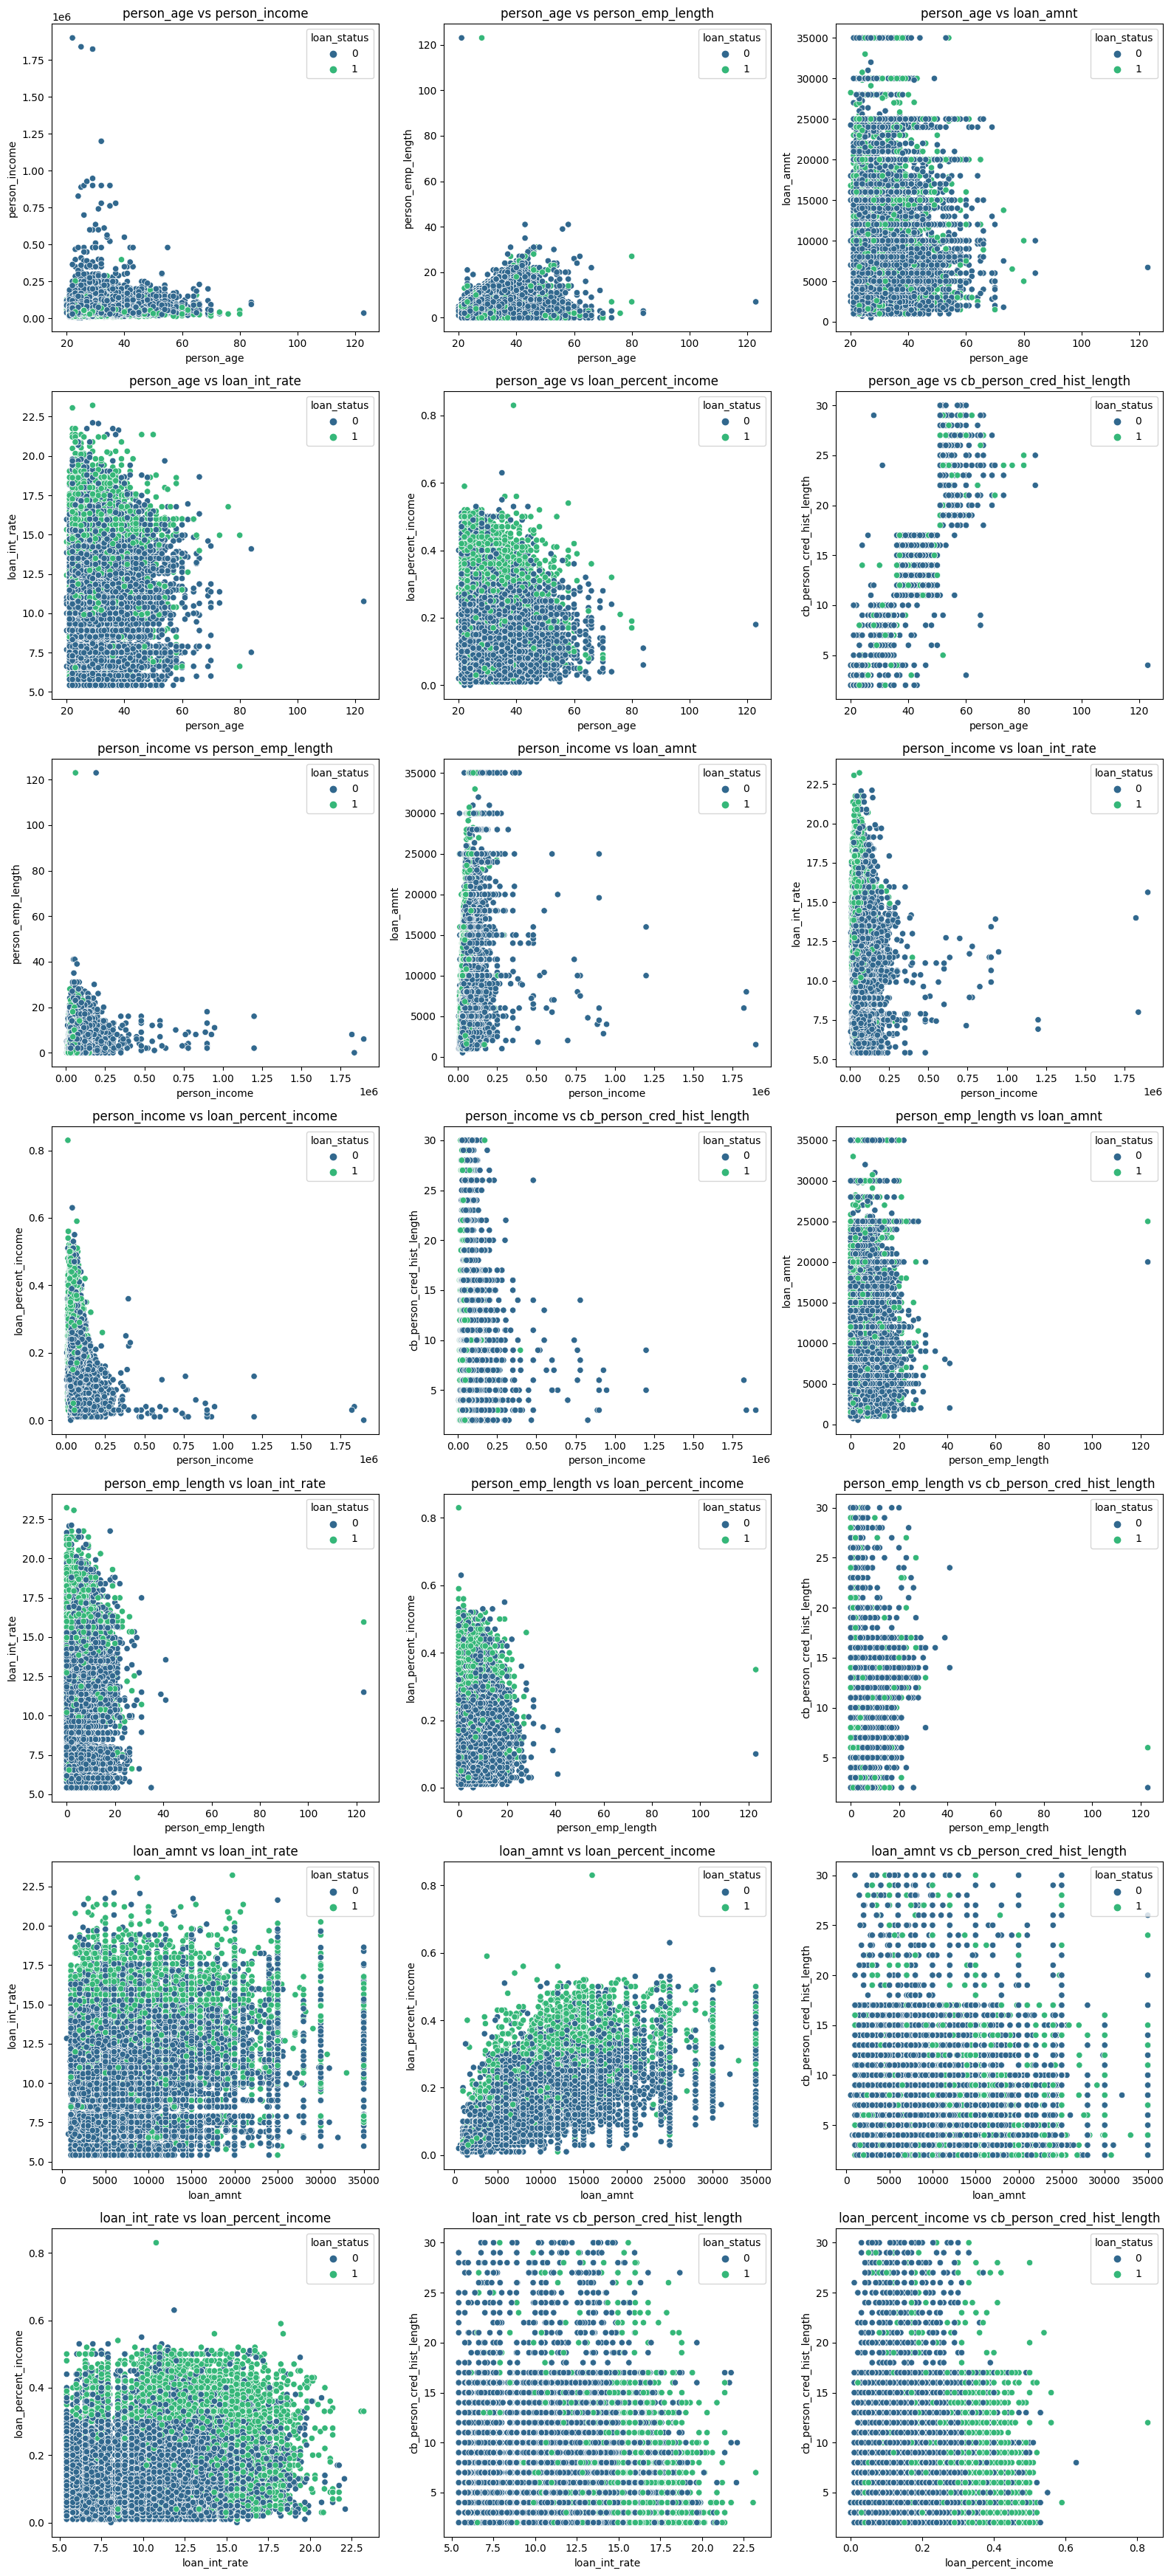

In [ ]:
import math
import itertools

# 篩選連續變數欄位
numeric_cols = df.select_dtypes(include=['number']).columns
numeric_cols = numeric_cols.drop('loan_status')  # 排除目標變數（如果在數值欄位中）

# 生成所有可能的欄位對組合
pairs = list(itertools.combinations(numeric_cols, 2))

# 計算行數和列數
ncols = 3
nrows = int(math.ceil(len(pairs) / ncols))

# 創建子圖
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 5 * nrows))
axes = axes.ravel()

# 繪製每組欄位對的散點圖
for i, (x_col, y_col) in enumerate(pairs):
    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue='loan_status',
        palette='viridis',
        ax=axes[i]
    )
    axes[i].set_title(f'{x_col} vs {y_col}')

# 隱藏多餘的子圖
for j in range(len(pairs), len(axes)):
    axes[j].set_visible(False)

# 調整布局
plt.tight_layout()
plt.show()


# 資料清洗

In [ ]:
df = df.dropna()
df = df.drop_duplicates()

In [ ]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

## 透過z-score分辨離群值

In [ ]:
from scipy.stats import zscore
z_scores = np.abs(zscore(df.select_dtypes(exclude='object').drop('loan_status', axis=1)))
# setting threshold out outliers as 3 stdev
threshold = 3

# detact and calculate amount and ratio of each column
outlier_counts = (z_scores > threshold).sum(axis=0)
outlier_ratios = outlier_counts / len(df) * 100

# make it into DataFrame
outliers_df = pd.DataFrame({
    'Outlier Count': outlier_counts,
    'Outlier Ratio (%)': outlier_ratios
})

print(outliers_df)


                            Outlier Count  Outlier Ratio (%)
person_age                           1010           1.722227
person_income                         533           0.908858
person_emp_length                     627           1.069145
loan_amnt                             345           0.588285
loan_int_rate                          66           0.112542
loan_percent_income                   459           0.782675
cb_person_cred_hist_length            492           0.838946


In [ ]:
# 查看各欄位的異常值

# 篩選出 Z-Score 大於 3 的行
outliers = df[(z_scores > 3).any(axis=1)]  # .any(axis=1) 確保對每行的任意一個特徵 Z-Score 大於 3 進行篩選

# 顯示原始資料中的異常值
for col in df.select_dtypes(exclude='object').columns:
    print(f"Outliers in {col}:")
    # 找到該欄位 Z-Score 大於 3 的行，顯示原始資料
    outlier_values = outliers[outliers[col].apply(lambda x: np.abs((x - df[col].mean()) / df[col].std()) > 3)]
    print(outlier_values[col].sort_values(ascending=False))  # 依照數值排序顯示異常值
    print("\n")

Outliers in person_age:
47336    123
4962      84
6750      84
15588     80
21953     80
        ... 
28990     46
27990     46
51289     46
27359     46
78        46
Name: person_age, Length: 1010, dtype: int64


Outliers in person_income:
17387    1900000
12404    1839784
37591    1824000
19060    1200000
2093     1200000
          ...   
32736     180000
43862     179000
26932     179000
49626     178364
26757     178008
Name: person_income, Length: 533, dtype: int64


Outliers in person_emp_length:
41079    123.0
49252    123.0
26125     41.0
9997      41.0
50559     39.0
         ...  
44393     17.0
14612     17.0
27877     17.0
14488     17.0
44575     17.0
Name: person_emp_length, Length: 627, dtype: float64


Outliers in loan_amnt:
30788    35000
30123    35000
24261    35000
24869    35000
25488    35000
         ...  
17701    26800
58149    26375
2616     26375
44114    26000
22994    26000
Name: loan_amnt, Length: 345, dtype: int64


Outliers in loan_int_rate:
53095    23.

除了有123歲跟123年受聘時間的資料點之外，異常值的產生主要是因為大部分貸款的都是年輕人

# 特徵工程 & 建立模型

In [ ]:
# 確認類別變數欄位
cat_col = df.select_dtypes(['object']).columns
for col in cat_col:
    print(col, df[col].unique())

person_home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent ['EDUCATION' 'MEDICAL' 'PERSONAL' 'VENTURE' 'DEBTCONSOLIDATION'
 'HOMEIMPROVEMENT']
loan_grade ['B' 'C' 'A' 'D' 'E' 'F' 'G']
cb_person_default_on_file ['N' 'Y']


類別變數：貸款人房屋持有情況、貸款目的、貸款等級評級、是否有失信紀錄

## 建立並訓練模型

ROC AUC Score: 0.9281


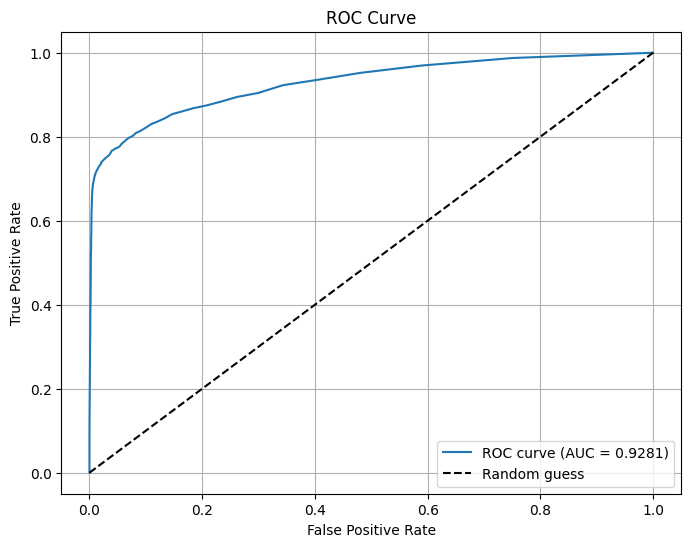

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設已經有 DataFrame df 並定義 categories_dict
categories_dict = {
    'person_home_ownership': ['OWN', 'RENT', 'MORTGAGE', 'OTHER'],
    'loan_grade': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    'cb_person_default_on_file': ['N', 'Y']
}

# 自定義頻率編碼函數
def frequency_encoding(column):
    freq = column.value_counts(normalize=True)
    return column.map(freq)

class FrequencyEncoder(FunctionTransformer):
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return input_features

# 定義頻率編碼變換器
frequency_encoder = FrequencyEncoder(
    lambda X: pd.DataFrame(X).apply(lambda col: frequency_encoding(col))
)

# 特徵處理
preprocessor = ColumnTransformer(
    transformers=[
        ('ownership', OrdinalEncoder(categories=[categories_dict['person_home_ownership']]), ['person_home_ownership']),
        ('grade', OrdinalEncoder(categories=[categories_dict['loan_grade']]), ['loan_grade']),
        ('cb', OrdinalEncoder(categories=[categories_dict['cb_person_default_on_file']]), ['cb_person_default_on_file']),
        ('intent', frequency_encoder, ['loan_intent'])
    ],
    remainder='passthrough'
)

# 建立完整的 pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# 分割資料
X = df.drop(columns=['loan_status'])  # 假設 loan_status 是目標欄位
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 模型訓練
pipeline.fit(X_train, y_train)

# 預測機率
y_prob = pipeline.predict_proba(X_test)[:, 1]  # 取得正樣本機率

# 計算 ROC AUC 分數
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {auc_score:.4f}")

# 繪製 ROC 曲線
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


## 確認模型在訓練集與測試集上的性能差異

In [ ]:
# 計算訓練集性能
y_train_pred_prob = pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_prob)

# 計算測試集性能
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_prob)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Train AUC: 1.0000
Test AUC: 0.9281


## 進行交叉驗證

In [ ]:
from sklearn.model_selection import cross_val_score

# 在訓練集進行 5 折交叉驗證
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation AUC scores: {cv_scores}")
print(f"Mean CV AUC: {cv_scores.mean():.4f}")


Cross-validation AUC scores: [0.93531011 0.9356773  0.94054257 0.93658407 0.92551577]
Mean CV AUC: 0.9347


## 上傳預測結果

In [ ]:
test_pred_prob = pipeline.predict_proba(df_test)[:, 1]

print(test_pred_prob[:10])


[0.92 0.   0.49 0.01 0.32 0.88 0.   0.01 0.1  0.  ]


In [ ]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_status': test_pred_prob
})

submission.to_csv('submission.csv', index=False)

print(submission.head())

      id  loan_status
0  58645         0.92
1  58646         0.00
2  58647         0.49
3  58648         0.01
4  58649         0.32


## 特徵重要性

                       Feature  Importance
9    cb_person_default_on_file    0.231512
8          loan_percent_income    0.139637
5                   loan_grade    0.118443
1                person_income    0.115647
0                   person_age    0.097336
3            person_emp_length    0.068285
7                loan_int_rate    0.066734
6                    loan_amnt    0.063156
4                  loan_intent    0.048869
10  cb_person_cred_hist_length    0.037434
2        person_home_ownership    0.012947


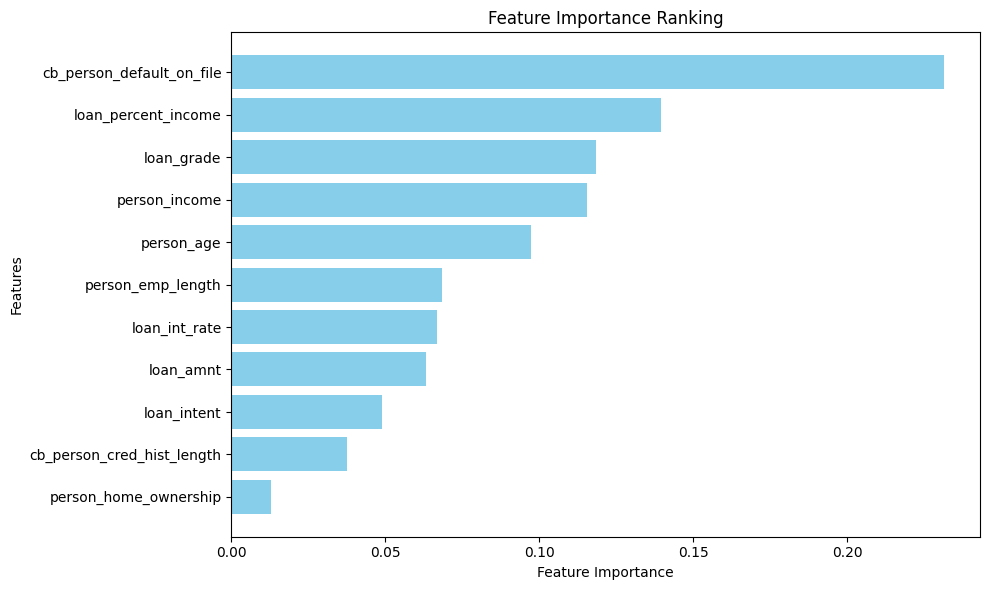

In [ ]:


# 訪問 pipeline 中的模型部分
model = pipeline.named_steps['classifier']

# 查看隨機森林模型的特徵重要性
importances = model.feature_importances_

# 取得變數名稱
feature_names = X_train.columns

# 整理成 DataFrame 便於查看
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 顯示特徵重要性
print(feature_importance_df)

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['Feature'],
    feature_importance_df['Importance'],
    color='skyblue'
)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.gca().invert_yaxis()  # 反轉 y 軸，讓重要性最高的特徵在頂部
plt.tight_layout()
plt.show()


# 結論：
從模型重要性中可以得知申請人過往是否有失信紀錄影響最高。
再來才是貸款金額與收入比例、貸款等級與申請人收入。